02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

c:\Users\kento.nishino.ek\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240627_train.csv')
test = pd.read_csv('../data/processed/processed20240627_test.csv')


In [3]:

# 特徴量と目的変数の設定
X = train.drop(columns=['target'])
y = train['target']


In [4]:
# 日付データの変換
if 'first_active_month' in X.columns:
    X['first_active_month'] = pd.to_datetime(X['first_active_month'])
    X['first_active_month_year'] = X['first_active_month'].dt.year
    X['first_active_month_month'] = X['first_active_month'].dt.month
    X = X.drop(columns=['first_active_month'])

In [5]:
# カテゴリカルデータの頻度ベースエンコーディング
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    freq_encoding = X[col].value_counts(normalize=True)
    X[col + '_freq'] = X[col].map(freq_encoding)
X = X.drop(columns=categorical_cols)

In [6]:
# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Optunaの目的関数
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        # 'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        # 'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.7, 0.9, 1.0]),
        # 'subsample': trial.suggest_categorical('subsample', [0.5, 0.7, 0.9, 1.0]),
        # 'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': 10000,
        # 'max_depth': trial.suggest_int('max_depth', 1, 15),
        # 'random_state': 42,
        # 'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = xgb.XGBRegressor(**param)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False
    )

    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    return rmse

In [9]:
# Optunaによるハイパーパラメータチューニング
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

[I 2024-06-27 16:55:44,512] A new study created in memory with name: no-name-42609282-322b-4dd4-ab4c-fc546e971fad
c:\Users\kento.nishino.ek\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\kento.nishino.ek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-27 16:55:56,654] Trial 0 finished with value: 3.716592501252254 and parameters: {}. Best is trial 0 with value: 3.716592501252254.


In [10]:
# 最適なパラメータの表示
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))


Best trial: score 3.716592501252254, params {}


In [11]:
# 最適なパラメータでモデルを再学習
best_params = study.best_trial.params
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

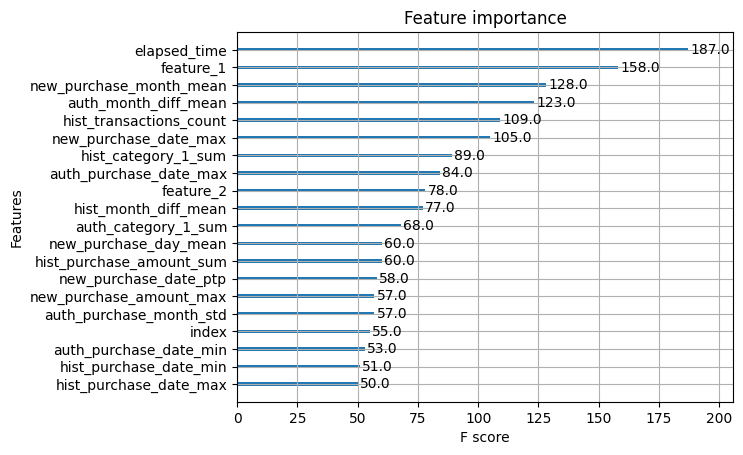

In [13]:
# 特徴量重要度の可視化
import matplotlib.pyplot as plt
import seaborn as sns
xgb.plot_importance(model, max_num_features=20)
plt.show()

## 提出ファイルの作成

In [ ]:
# 目的変数の分布を確認
sns.distplot(rmse)